In [85]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [86]:
# Проверяем видео-карту
!nvidia-smi

Sun May  2 21:33:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [87]:
# Загружаем kaggle 
!pip install kaggle

In [88]:
# Подключаем диск и загружаем json 
from google.colab import files
files.upload()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# Прописываем директории для данных 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [90]:
# Загружаем данные с kaggle
!kaggle competitions download -c mts-ml-summer-school

users.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
items.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
interactions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [91]:
# Проверяем директорию с данными
!ls

date   interactions.csv.zip  kaggle.json  sample_submission.csv
drive  items.csv.zip	     sample_data  users.csv.zip


# Loading Data 
Предоставлены данные из приложения МТС Библиотека по взаимодействиям пользователей с книгами за 2 года.

В отдельных файлах есть:

- факты чтения книг пользователями
- описание книг
- описание пользователей

In [92]:
# Проверяем наличие папки sound. Если есть, удаляем ее
!rm -R /content/date

In [93]:
# Извлекаем данные
!unzip -q '/content/interactions.csv.zip' -d '/content/date'
!unzip -q '/content/items.csv.zip' -d '/content/date'
!unzip -q '/content/users.csv.zip' -d '/content/date'

In [165]:
# Функция для построения гистограммы
def get_plot_col_distribution(df, num_show, num_row):
  nunique = df.nunique()
  df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
  n_row, n_col = df.shape
  col_names = list(df)
  n_graph_row = (n_col + num_row - 1) / num_row
  plt.figure(num = None, figsize = (6 * num_row, 8 * n_graph_row), dpi = 80, 
             facecolor = 'w', edgecolor = 'k')
  for i in range(min(n_col, num_show)):
    plt.subplot(n_graph_row, num_row, i + 1)
    col_df = df.iloc[:, i]
    if (not np.issubdtype(type(col_df.iloc[0]), np.number)):
      value_count = col_df.value_counts()
      value_count.plot.bar()
    else:
      col_df.hist()
    plt.ylabel('counts')
    plt.xticks(rotation = 90)
    plt.title(f'{col_names[i]} (column {i})')
  plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
  plt.show()


# Функция для построения корреляционной матрицы
def get_plot_corr_matrix(df, num_width):
  fn = df.dataframeName
  df = df.dropna('columns')
  df = df[[col for col in df if df[col].nunique() > 1]]
  if df.shape[1] < 2:
    print(f'Отсутствует корреляция ({df.shape[1]}) меньше чем 2!')
    return
  corr = df.corr()
  plt.figure(num = None, figsize = (num_width, num_width), dpi = 80, 
             facecolor = 'w', edgecolor = 'k')
  corr_matrix = plt.matshow(corr, fignum = 1)
  plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
  plt.yticks(range(len(corr.columns)), corr.columns)
  plt.gca().xaxis.tick_bottom()
  plt.colorbar(corr_matrix)
  plt.title(f'Матрица Корреляции:\n{fn}', fontsize = 15)
  plt.show()


# Функция для построения точечной диаграммы
def get_plot_scatter(df, plot_size, text_size):
  df = df.select_dtypes(include=[np.number])
  df = df.dropna('columns')
  df = df[[col for col in df if df[col].nunique() > 1]]
  col_names = list(df)
  if len(col_names) > 10:
    col_names = col_names[:10]
  df = df[col_names]
  ax = pd.plotting.scatter_matrix(df, alpha = 0.75, 
                                  figsize = [plot_size, plot_size], diagonal = 'kde')
  corrs = df.corr().values
  for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
    ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), 
                      xycoords='axes fraction', ha='center', va='center', size = text_size)
  plt.suptitle('Точечная диаграмма')
  plt.show()


# Функция для записи в .csv
def get_to_csv(df, fn):
  pred = []
  ids = []
  for id, rec in tqdm(df.groupby('user_id')):
    ids += [id]
    pred += [' '.join(map(str, rec['item_id'].values[0]))]
  my_submission = pd.DataFrame({'Id': ids, 'Predicted': pred})
  sub = pd.read_csv('/content/sample_submission.csv')
  my_submission = sub['Id'].to_frame().merge(my_submission, on = 'Id', how = 'left')
  my_submission.to_csv(fn, index = False)
  return my_submission


# Функция для оценки системы
def get_score(rec_df, train_data, num = 10, print_met=False):
  pred_rec = rec_df.explode('item_id')
  pred_rec['rank'] = pred_rec.groupby('user_id').cumcount() + 1
  pred_rec = train_data.set_index(['user_id', 'item_id']).join(
      pred_rec.set_index(['user_id', 'item_id']))
  pred_rec = pred_rec.sort_values(by=['user_id', 'rating'])
  pred_rec['user_all_book'] = tqdm(pred_rec.groupby(level = 'user_id', 
                                                    sort = False)['rank'].transform(np.size))
  pred_rec['reciprocal_rank'] = 1 / pred_rec['rank']
  pred_rec['reciprocal_rank'] = pred_rec['reciprocal_rank'].fillna(0)
  pred_rec['cumulative_rank'] = pred_rec.groupby(level='user_id').cumcount() + 1
  pred_rec['cumulative_rank'] = pred_rec['cumulative_rank'] / pred_rec['rank']

  metrics = {f'MAPE: {num}': [], f'MRR': []}
  users_count = pred_rec.index.get_level_values('user_id').nunique()
  for i in range(1, num + 1):
    best_i = f'hit: {i}'
    pred_rec[best_i] = pred_rec['rank'] <= i
    if print_met:
      print(f'Precission: {i} = {(pred_rec[best_i] / i).sum() / users_count:.2f}')
      print(f'Recall: {i} = {(pred_rec[best_i] / pred_rec["user_all_book"]).sum() / users_count:.2f}')

  MAPE = (pred_rec['cumulative_rank'] / pred_rec['user_all_book']).sum() / users_count
  metrics[f'MAPE: {num}'] += [MAPE]
  MRR = pred_rec.groupby(level='user_id')['reciprocal_rank'].max().mean()
  metrics['MRR'] += [MRR]
  if print_met:
    print(f'MAPE: {num} = {round(MAPE, 2)}')
    print(f'MRR = {round(mrr, 2)}')

  return metrics

In [95]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

from more_itertools import pairwise
from tqdm.auto import tqdm
import scipy.sparse as sp
from itertools import islice, cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [96]:
# Загрузим данные из csv
PATH = '/content/date/'

users_df = pd.read_csv(PATH + 'users.csv')
users_df.dataframeName = 'users.csv'

items_df = pd.read_csv(PATH + 'items.csv')
items_df.dataframeName = 'items.csv'

interactions_df = pd.read_csv(PATH + 'interactions.csv')
interactions_df.dataframeName = 'interactions.csv'

In [97]:
# Выведем df c фактами чтения книг пользователями и инфу о df
display(interactions_df)
interactions_df.info()

,user_id,item_id,progress,rating,start_date
0,90133,82910,100,NaN,2018-01-01
1,159130,331068,70,NaN,2018-01-01
2,80061,26540,69,4.0,2018-01-01
3,12811,301895,16,NaN,2018-01-01
4,5778,127872,100,NaN,2018-01-01
...,...,...,...,...,...
1562612,978,321492,50,NaN,2019-12-31
1562613,165713,325032,9,NaN,2019-12-31
1562614,43983,96797,100,5.0,2019-12-31
1562615,63445,157812,5,0.0,2019-12-31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562617 entries, 0 to 1562616
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1562617 non-null  int64  
 1   item_id     1562617 non-null  int64  
 2   progress    1562617 non-null  int64  
 3   rating      323571 non-null   float64
 4   start_date  1562617 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 59.6+ MB


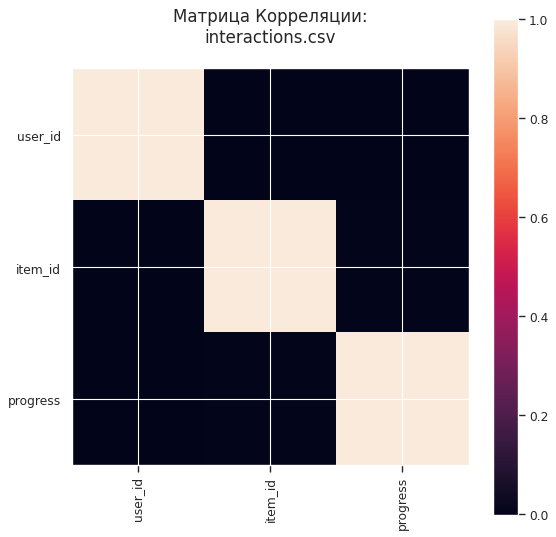

In [98]:
get_plot_corr_matrix(interactions_df, 8)

In [99]:
# Преобразуем object в datetime
interactions_df['start_date'] = pd.to_datetime(interactions_df['start_date'])
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562617 entries, 0 to 1562616
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1562617 non-null  int64         
 1   item_id     1562617 non-null  int64         
 2   progress    1562617 non-null  int64         
 3   rating      323571 non-null   float64       
 4   start_date  1562617 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 59.6 MB


In [100]:
# Проверим на дубликаты
dublicates = interactions_df.duplicated(subset=['user_id', 'item_id'], keep=False)
print(f'Количество дублирующихся значений: {dublicates.sum()}')

Количество дублирующихся значений: 224


In [101]:
# Сортируем и оставляем уникальные значения
dublicates_df = interactions_df[dublicates].sort_values(by=['user_id', 'start_date'])
interactions_df = interactions_df[~dublicates]

# Добавим инфу в дубликатах
dublicates_df = dublicates_df.groupby(['user_id', 'item_id']).agg({
    'progress': 'max',
    'rating': 'max',
    'start_date': 'min'})
interactions_df = interactions_df.append(dublicates_df.reset_index(), ignore_index=True)

# Укажем тип данных в df
interactions_df['progress'] = interactions_df['progress'].astype(np.int8)
interactions_df['rating'] = interactions_df['rating'].astype(pd.SparseDtype(np.float32, np.nan))
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562505 entries, 0 to 1562504
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype               
---  ------      --------------    -----               
 0   user_id     1562505 non-null  int64               
 1   item_id     1562505 non-null  int64               
 2   progress    1562505 non-null  int8                
 3   rating      323563 non-null   Sparse[float32, nan]
 4   start_date  1562505 non-null  datetime64[ns]      
dtypes: Sparse[float32, nan](1), datetime64[ns](1), int64(2), int8(1)
memory usage: 39.7 MB


In [102]:
# Выведем описание книг и информацию о df
display(items_df)
items_df.info(memory_usage='full')

,id,title,genres,authors,year
0,248031,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная классика,Литература 19 века,Русская классика",Михаил Салтыков-Щедрин,1886
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская классика",Антон Чехов,1894
2,134166,Испорченные дети,"Зарубежная классика,Классическая проза,Литература 19 века,Русская классика",Михаил Салтыков-Щедрин,1869
3,281311,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,213473,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литература 19 века,Русская классика",Михаил Салтыков-Щедрин,1873
...,...,...,...,...,...
63753,143203,Игрушка палача,"Эротические романы,Любовно-фантастические романы,Остросюжетные любовные романы",Эрика Адамс,2019
63754,27324,Любовь под развесистой клюквой,Современные любовные романы,Маргарита Южина,NaN
63755,359711,"Куда уходят грешницы, или Гробница Наполеона",Современные детективы,Наталья Андреева,NaN
63756,283955,Сварить медведя,"Зарубежные детективы,Исторические детективы,Зарубежные приключения,Исторические приключения",Микаель Ниеми,2017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63758 entries, 0 to 63757
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       63758 non-null  int64 
 1   title    63758 non-null  object
 2   genres   63753 non-null  object
 3   authors  56700 non-null  object
 4   year     49508 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


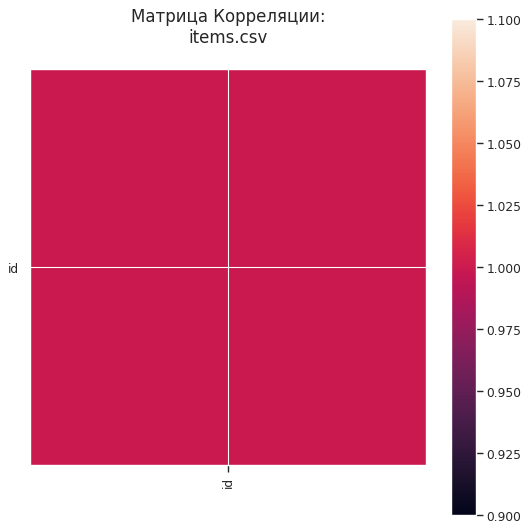

In [103]:
get_plot_corr_matrix(items_df, 8)

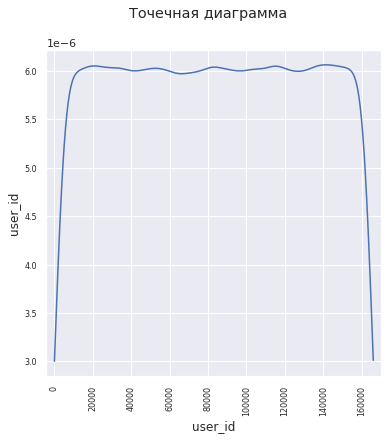

In [104]:
get_plot_scatter(users_df, 6, 15)

In [105]:
# Функция для форматирования данных
def get_bytes_format(num, float_prec=4):
  units = ['bytes', 'Kb', 'Mb', 'Gb', 'Tb', 'Pb', 'Eb']
  for unit in units[:-1]:
    if abs(num) < 1000:
      return f'{num:.{float_prec}f} {unit}'
    num /= 1000
  return f'{num:.4f} {units[-1]}'

num = items_df.memory_usage(deep=True).sum()
get_bytes_format(num)

'33.5358 Mb'

In [106]:
# Подсчитаем уникальные значения
items_df.nunique()

id         63758
title      58093
genres     11091
authors    17024
year        1074
dtype: int64

In [107]:
# Изменим тип данных
for col in ['genres', 'authors', 'year']:
  items_df[col] = items_df[col].astype('category')

items_df.info(memory_usage='full')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63758 entries, 0 to 63757
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       63758 non-null  int64   
 1   title    63758 non-null  object  
 2   genres   63753 non-null  category
 3   authors  56700 non-null  category
 4   year     49508 non-null  category
dtypes: category(3), int64(1), object(1)
memory usage: 2.5+ MB


In [108]:
num = items_df.memory_usage(deep=True).sum()
get_bytes_format(num)

'18.6994 Mb'

In [109]:
# Посмотрим взаимодействия книг
interactions_items = interactions_df['item_id'].unique()

items = len(np.intersect1d(interactions_items, items_df['id']))
items_interaction = len(np.setdiff1d(interactions_items, items_df['id']))
items_features = len(np.setdiff1d(items_df['id'], interactions_items))
total_items = items + items_interaction + items_features

print(f'Количество книг: {total_items}')
print(f'Количество книг с взаимодействиями и фичами: {items} ({items / total_items * 100:.2f}%)')
print(f'Количество книг только с взаимодействиями: {items_interaction} ({items_interaction / total_items * 100:.2f}%)')
print(f'Количество книг с фичами: {items_features} ({items_features / total_items * 100:.2f}%)')

Количество книг: 63758
Количество книг с взаимодействиями и фичами: 63758 (100.00%)
Количество книг только с взаимодействиями: 0 (0.00%)
Количество книг с фичами: 0 (0.00%)


In [110]:
# Выведем описание пользователей и инфу о df
display(users_df)
users_df.info()

,user_id,age,sex
0,0,45_54,1.0
1,1,25_34,0.0
2,2,45_54,0.0
3,3,65_inf,0.0
4,4,18_24,0.0
...,...,...,...
137249,166060,25_34,0.0
137250,166061,35_44,1.0
137251,166062,45_54,1.0
137252,166065,25_34,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137254 entries, 0 to 137253
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  137254 non-null  int64  
 1   age      137244 non-null  object 
 2   sex      135640 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ MB


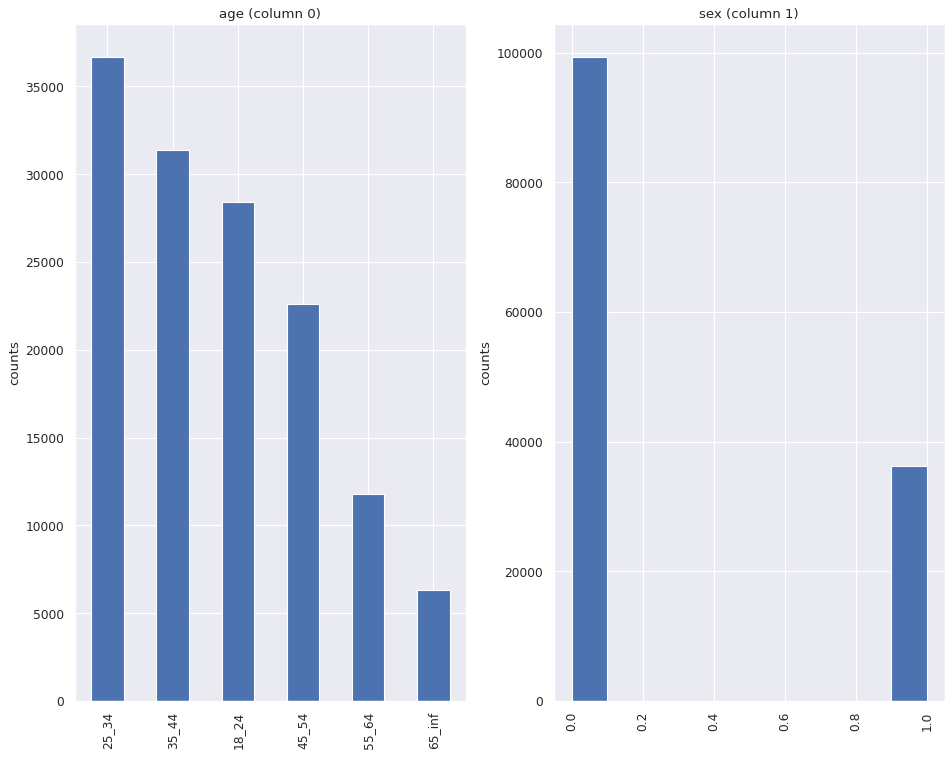

In [111]:
get_plot_col_distribution(users_df, 10, 5)

In [112]:
get_plot_corr_matrix(users_df, 8)

Отсутствует корреляция (1) меньше чем 2!


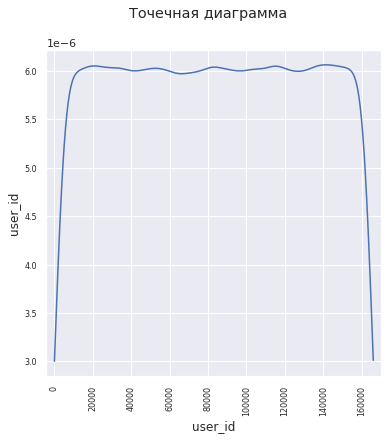

In [113]:
get_plot_scatter(users_df, 6, 15)

In [114]:
# Изменим тип и подсчитаем уникальные значения
users_df['age'] = users_df['age'].astype('category')
users_df['sex'] = users_df['sex'].astype(pd.SparseDtype(np.float32, np.nan))
users_df.nunique()

user_id    137254
age             6
sex             2
dtype: int64

In [115]:
# Посмотрим взаимодействия пользователей
interactions_users = interactions_df['user_id'].unique()

users = len(np.intersect1d(interactions_users, users_df['user_id']))
users_iteraction = len(np.setdiff1d(interactions_users, users_df['user_id']))
users_features = len(np.setdiff1d(users_df['user_id'], interactions_users))
total_users = users + users_iteraction + users_features

print(f'Количество пользователей: {total_users}')
print(f'Количество взаимодействиями и фичами: {users} ({users / total_users * 100:.2f}%)')
print(f'Количество пользователей только с взаимодействиями: {users_iteraction} ({users_iteraction / total_users * 100:.2f}%)')
print(f'Количество пользователей с фичами: {users_features} ({users_features / total_users * 100:.2f}%)')

Количество пользователей: 164771
Количество взаимодействиями и фичами: 130808 (79.39%)
Количество пользователей только с взаимодействиями: 27517 (16.70%)
Количество пользователей с фичами: 6446 (3.91%)


# Preprocessing Data

In [118]:
# Сопаставим индексы для данных
users_map = dict(enumerate(interactions_df['user_id'].unique()))
users_mapping = {v: k for k, v in users_map.items()}

items_map = dict(enumerate(interactions_df['item_id'].unique()))
items_mapping = {v: k for k, v in items_map.items()}

# Приведем к единому размеру название книг
items_df['title'] = items_df['title'].str.lower()
items_titles = pd.Series(items_df['title'].values, index = items_df['id']).to_dict()

# Create System

Наиболее точно порекомендовать список из 10 книг для каждого пользователя из тестовой выборки.

🎯 Цель соревнования - разобраться, как работают базовые модели рекомендаций и попробовать улучшить их результат.

In [140]:
# Создадим класс рекомендательной системы
class RecSys():
  def __init__(self, max_ = 100, days = 10, item_col = 'item_id', date_col = 'date'):
    self.recomm = []
    self.max_ = max_
    self.days = days
    self.item_col = item_col
    self.date_col = date_col

  def get_fit(self, df, ):
    start_date = df[self.date_col].max().normalize() - pd.DateOffset(days=self.days)
    self.recomm = df.loc[df[self.date_col] > start_date, 
                         self.item_col].value_counts().head(self.max_).index.values

  def get_recomm(self, users=None, num = 10):
    recs = self.recomm[:num].astype(int)
    if users is None:
      return recs
    else:
      return list(islice(cycle([recs]), len(users)))


In [141]:
# Загрузим проверочный файл
submission = pd.read_csv('/content/sample_submission.csv')
submission.columns = ['user_id', 'Predicted']

# Обозначим количество дней
full_days = (interactions_df['start_date'].unique().max() - interactions_df['start_date'].
             unique().min()).astype('timedelta64[D]').astype('int')

# Cоздадим тренировочный датасет
train_data = submission['user_id'].to_frame().merge(interactions_df, on = 'user_id', how = 'left')
submission.columns = ['Id', 'Predicted']


# Fit and Test System

In [142]:
# Создаем модель и обучаем
model = RecSys(days = 729, date_col = 'start_date')
model.get_fit(train_data)

recommendation = model.get_recomm()
recommendation

array([ 80576,  37493,  68956,  75731, 270299, 364794, 330824, 178529,
       104445, 211600])

In [143]:
# Проверяем рекомендации
list(map(items_titles.get, recommendation))

['сила подсознания, или как изменить жизнь за 4 недели',
 'снеговик',
 'невеста смерти',
 'земное притяжение',
 'цена вопроса. том 1',
 'долина драконов. магическая практика',
 'струны волшебства. книга первая. страшные сказки закрытого королевства',
 'яблоки из сада шлицбутера',
 'чудовищное предложение',
 'магическая сделка']

In [155]:
# Возьмем рекомендации для 10 пользователей
pred_rec = pd.DataFrame({'user_id': train_data['user_id'].unique()})
num = 10
pred_rec['item_id'] = model.get_recomm(pred_rec['user_id'], num = num)
pred_rec.head(10)

,user_id,item_id
0,10001,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
1,10002,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
2,100152,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
3,100197,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
4,100284,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
5,10031,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
6,100412,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
7,100428,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
8,100450,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"
9,100562,"[80576, 37493, 68956, 75731, 270299, 364794, 330824, 178529, 104445, 211600]"


In [159]:
# Сохраним результат
my_submission = get_to_csv(pred_rec, '/content/date/sample_submission.csv')

my_submission.head(10)

,Id,Predicted
0,10001,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
1,10002,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
2,100152,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
3,100197,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
4,100284,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
5,10031,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
6,100412,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
7,100428,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
8,100450,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600
9,100562,80576 37493 68956 75731 270299 364794 330824 178529 104445 211600


In [164]:
# Оценим модель
metrics = get_score(pred_rec, train_data)
print(metrics)


{'MAPE: 10': [0.03727178267234922], 'MRR': [0.061716418295793704]}


In [167]:
!kaggle competitions submit  -c mtc-ml-summer-school -f 'content/date/sample_submission.csv' -m "Test First"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 544, in competition_submit_cli
    competition, quiet)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 495, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/usr/lib/python2.7/genericpath.py", line 57, in getsize
    return os.stat(filename).st_size
OSError: [Errno 2] No such file or directory: 'content/date/sample_submission.csv'
